In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
import numpy as np
from itertools import chain
from copy import deepcopy
import pydicom
from skimage.io import imread, imshow

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
3006   00000798_018.png     No Finding           18         798           65   
70057  00017244_001.png     No Finding            1       17244           39   
51787  00013077_015.png     No Finding           15       13077           65   

      Patient Gender View Position  OriginalImage[Width  Height]  \
3006               F            AP                 2500     2048   
70057              M            PA                 2992     2991   
51787              M            PA                 2992     2991   

       OriginalImagePixelSpacing[x     y]  Unnamed: 11  
3006                         0.168  0.168          NaN  
70057                        0.143  0.143          NaN  
51787                        0.143  0.143          NaN

In [3]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

Image Index         Finding Labels  Follow-up #  Patient ID  \
4485  00022335_011.png               Effusion           11       22335   
95    00000545_000.png  Effusion|Infiltration            0         545   
3518  00017333_002.png             No Finding            2       17333   

     Patient Age Patient Gender View Position  OriginalImageWidth  \
4485        054Y              M            PA                2992   
95          046Y              M            PA                2992   
3518        039Y              F            PA                2992   

      OriginalImageHeight  OriginalImagePixelSpacing_x  \
4485                 2991                        0.143   
95                   2991                        0.143   
3518                 2991                        0.143   

      OriginalImagePixelSpacing_y  
4485                        0.143  
95                          0.143  
3518                        0.143

# 1. The patient demographic data such as gender, age, patient view position, etc. (as it is available)

In [4]:
#locations in NIH dataframe where patient age is exceedingly large
all_xray_df.loc[all_xray_df['Patient Age'] >= 110]

Image Index           Finding Labels  Follow-up #  Patient ID  \
20852   00005567_000.png       Effusion|Pneumonia            0        5567   
46965   00011973_002.png                    Edema            2       11973   
48284   00012238_010.png               No Finding           10       12238   
55742   00013950_000.png               No Finding            0       13950   
58650   00014520_026.png        Infiltration|Mass           26       14520   
62929   00015558_000.png               No Finding            0       15558   
74884   00018366_044.png             Pneumothorax           44       18366   
78795   00019346_000.png             Infiltration            0       19346   
84810   00020900_002.png               No Finding            2       20900   
85404   00021047_002.png  Mass|Pleural_Thickening            2       21047   
86264   00021275_003.png               No Finding            3       21275   
91369   00022811_000.png               No Finding            0       22811   
95794   00025206_000.png        Infiltration|Mass            0       25206   
98495   00026028_001.png              Atelectasis            1       26028   
101194  00026871_000.png               No Finding            0       26871   
104590  00027989_000.png               No Finding            0       27989   

        Patient Age Patient Gender View Position  OriginalImage[Width  \
20852           412              M            AP                 3056   
46965           414              M            AP                 3056   
48284           148              M            PA                 2992   
55742           148              M            PA                 2964   
58650           150              M            PA                 2992   
62929           149              M            PA                 2992   
74884           152              F            PA                 2302   
78795           151              F            PA                 2678   
84810           411              M            AP                 3056   
85404           412              M            AP                 3056   
86264           413              F            AP                 3056   
91369           412              M            PA                 3056   
95794           153              M            PA                 2992   
98495           154              M            PA                 2992   
101194          155              F            PA                 2992   
104590          155              M            PA                 2992   

        Height]  OriginalImagePixelSpacing[x     y]  Unnamed: 11  
20852      2544                        0.139  0.139          NaN  
46965      2544                        0.139  0.139          NaN  
48284      2991                        0.143  0.143          NaN  
55742      2939                        0.143  0.143          NaN  
58650      2991                        0.143  0.143          NaN  
62929      2991                        0.143  0.143          NaN  
74884      2991                        0.143  0.143          NaN  
78795      2774                        0.143  0.143          NaN  
84810      2544                        0.139  0.139          NaN  
85404      2544                        0.139  0.139          NaN  
86264      2544                        0.139  0.139          NaN  
91369      2544                        0.139  0.139          NaN  
95794      2991                        0.143  0.143          NaN  
98495      2991                        0.143  0.143          NaN  
101194     2991                        0.143  0.143          NaN  
104590     2991                        0.143  0.143          NaN

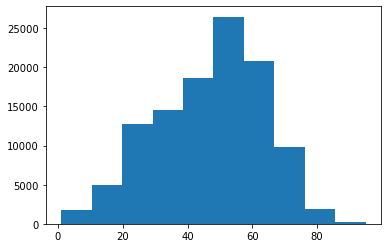

In [5]:
#remove all entries with patient ages greater than 110, as they are most likely wrong readings by NLP labeler
new_all_xray_df = all_xray_df.drop(all_xray_df.loc[all_xray_df['Patient Age'] >= 110].index)

#plot histogram of patient ages with erroneous rows dropped
ax = plt.hist(new_all_xray_df['Patient Age'])
# new_all_xray_df['Patient Age'].value_counts()

In [6]:
# new_all_xray_df['Patient Age'].value_counts()
print("max patient age is : ", new_all_xray_df['Patient Age'].max())
print("min patient age is : ", new_all_xray_df['Patient Age'].min())

max patient age is :  95
min patient age is :  1


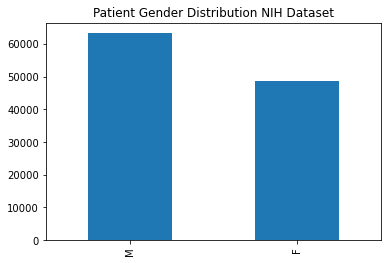

In [7]:
# Distribution of Patient Genders in NIH Dataset
new_all_xray_df['Patient Gender'].value_counts().plot(kind = 'bar', title = 'Patient Gender Distribution NIH Dataset')

In [8]:
print("Male Patient Count: ", new_all_xray_df['Patient Gender'].value_counts()['M'])
print("Female Patient Count: ", new_all_xray_df['Patient Gender'].value_counts()['F'])
print("Total: ", new_all_xray_df['Patient Gender'].value_counts().sum())

Male Patient Count:  63328
Female Patient Count:  48776
Total:  112104


# 2. X-Ray Views Taken (View Position)

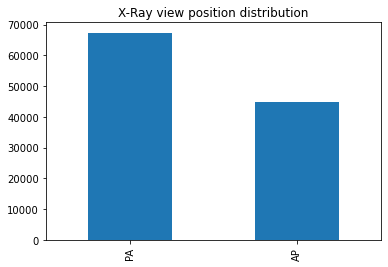

In [9]:
new_all_xray_df['View Position'].value_counts().plot(kind = 'bar', title= 'X-Ray view position distribution')

# 3. The number of cases including:
 - number of pneumonia cases,
 - number of non-pneumonia cases

In [10]:
new_all_xray_df['Finding Labels'].value_counts()
#you have to separate the text in finding labels

No Finding                                                 60353
Infiltration                                                9546
Atelectasis                                                 4214
Effusion                                                    3955
Nodule                                                      2705
                                                           ...  
Cardiomegaly|Consolidation|Effusion|Infiltration|Nodule        1
Effusion|Emphysema|Infiltration|Nodule|Pneumothorax            1
Effusion|Emphysema|Infiltration|Nodule                         1
Emphysema|Fibrosis|Infiltration|Pneumothorax                   1
Atelectasis|Consolidation|Emphysema|Mass|Pneumothorax          1
Name: Finding Labels, Length: 836, dtype: int64

In [11]:
all_labels = np.unique(list(chain(*new_all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))

all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    new_all_xray_df[c_label] = new_all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
new_all_xray_df.head(4)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   

   OriginalImagePixelSpacing[x  ...  Emphysema  Fibrosis  Hernia  \
0                        0.143  ...        0.0       0.0     0.0   
1                        0.143  ...        1.0       0.0     0.0   
2                        0.168  ...        0.0       0.0     0.0   
3                        0.171  ...        0.0       0.0     0.0   

   Infiltration  Mass  No Finding  Nodule  Pleural_Thickening  Pneumonia  \
0           0.0   0.0         0.0     0.0                 0.0        0.0   
1           0.0   0.0         0.0     0.0                 0.0        0.0   
2           0.0   0.0         0.0     0.0                 0.0        0.0   
3           0.0   0.0         1.0     0.0                 0.0        0.0   

   Pneumothorax  
0           0.0  
1           0.0  
2           0.0  
3           0.0  

[4 rows x 27 columns]

In [12]:
# proportion of each finding label in NIH dataset
new_all_xray_df[all_labels].sum() #/len(new_all_xray_df) # * 100 # to get percent

Atelectasis           11558.0
Cardiomegaly           2776.0
Consolidation          4667.0
Edema                  2302.0
Effusion              13316.0
Emphysema              2516.0
Fibrosis               1686.0
Hernia                  227.0
Infiltration          19891.0
Mass                   5779.0
No Finding            60353.0
Nodule                 6331.0
Pleural_Thickening     3384.0
Pneumonia              1430.0
Pneumothorax           5301.0
dtype: float64

[Text(0, 0.5, 'Number of Images with Label')]

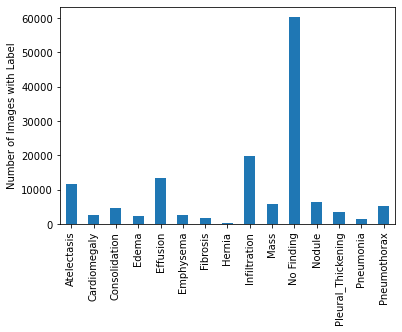

In [13]:
ax = new_all_xray_df[all_labels].sum().plot(kind='bar') #plot the total number (sum) of cases under each label in 'all_labels'
ax.set(ylabel = 'Number of Images with Label')

In [14]:
# total number of pneumonia cases
pneumonia_case_count = new_all_xray_df[all_labels].sum()['Pneumonia']
pneumonia_case_count

1430.0

In [15]:
#total number of non-pneumonia cases
ser = new_all_xray_df[all_labels].sum()
total_count = ser.sum() 
non_pneumonia_case_count = total_count - pneumonia_case_count
non_pneumonia_case_count

140087.0

# 4. The distribution of other diseases that are comordbid with pneumonia

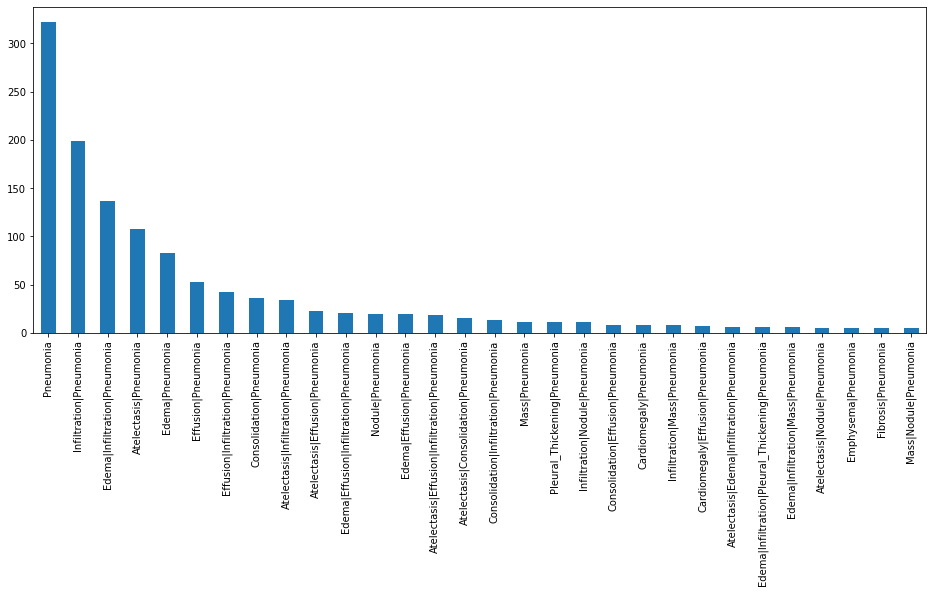

In [16]:
#first 30 most common findings that are co-morbid with pneumonia
plt.figure(figsize=(16,6))
new_all_xray_df[new_all_xray_df['Pneumonia'] == 1]['Finding Labels'].value_counts()[0:30].plot(kind = 'bar')

# 5. Number of disease per patient

In [17]:
all_labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [18]:
all_xray_disease_df = new_all_xray_df.drop(columns = ['No Finding'])
all_xray_disease_df

diseases = deepcopy(all_labels)
diseases.remove('No Finding')

all_xray_disease_df['Disease Count'] = all_xray_disease_df[diseases].sum(axis = 1)

In [19]:
all_xray_disease_df

Image Index          Finding Labels  Follow-up #  Patient ID  \
0       00000001_000.png            Cardiomegaly            0           1   
1       00000001_001.png  Cardiomegaly|Emphysema            1           1   
2       00000001_002.png   Cardiomegaly|Effusion            2           1   
3       00000002_000.png              No Finding            0           2   
4       00000003_000.png                  Hernia            0           3   
...                  ...                     ...          ...         ...   
112115  00030801_001.png          Mass|Pneumonia            1       30801   
112116  00030802_000.png              No Finding            0       30802   
112117  00030803_000.png              No Finding            0       30803   
112118  00030804_000.png              No Finding            0       30804   
112119  00030805_000.png              No Finding            0       30805   

        Patient Age Patient Gender View Position  OriginalImage[Width  \
0                58              M            PA                 2682   
1                58              M            PA                 2894   
2                58              M            PA                 2500   
3                81              M            PA                 2500   
4                81              F            PA                 2582   
...             ...            ...           ...                  ...   
112115           39              M            PA                 2048   
112116           29              M            PA                 2048   
112117           42              F            PA                 2048   
112118           30              F            PA                 2048   
112119           27              M            PA                 2048   

        Height]  OriginalImagePixelSpacing[x  ...  Emphysema  Fibrosis  \
0          2749                        0.143  ...        0.0       0.0   
1          2729                        0.143  ...        1.0       0.0   
2          2048                        0.168  ...        0.0       0.0   
3          2048                        0.171  ...        0.0       0.0   
4          2991                        0.143  ...        0.0       0.0   
...         ...                          ...  ...        ...       ...   
112115     2500                        0.168  ...        0.0       0.0   
112116     2500                        0.168  ...        0.0       0.0   
112117     2500                        0.168  ...        0.0       0.0   
112118     2500                        0.168  ...        0.0       0.0   
112119     2500                        0.171  ...        0.0       0.0   

        Hernia  Infiltration  Mass  Nodule  Pleural_Thickening  Pneumonia  \
0          0.0           0.0   0.0     0.0                 0.0        0.0   
1          0.0           0.0   0.0     0.0                 0.0        0.0   
2          0.0           0.0   0.0     0.0                 0.0        0.0   
3          0.0           0.0   0.0     0.0                 0.0        0.0   
4          1.0           0.0   0.0     0.0                 0.0        0.0   
...        ...           ...   ...     ...                 ...        ...   
112115     0.0           0.0   1.0     0.0                 0.0        1.0   
112116     0.0           0.0   0.0     0.0                 0.0        0.0   
112117     0.0           0.0   0.0     0.0                 0.0        0.0   
112118     0.0           0.0   0.0     0.0                 0.0        0.0   
112119     0.0           0.0   0.0     0.0                 0.0        0.0   

        Pneumothorax  Disease Count  
0                0.0            1.0  
1                0.0            2.0  
2                0.0            2.0  
3                0.0            0.0  
4                0.0            1.0  
...              ...            ...  
112115           0.0            2.0  
112116           0.0            0.0  
112117           0.0            0.0  
112118           

In [20]:
all_xray_disease_df['Patient ID'].min()

1

In [21]:
all_xray_disease_df['Patient ID'].max()

30805

In [22]:
all_xray_disease_df['Patient ID'].value_counts()

10007    184
13670    173
15530    158
12834    157
13993    143
        ... 
13538      1
3301       1
5350       1
7399       1
22485      1
Name: Patient ID, Length: 30802, dtype: int64

In [23]:
all_xray_disease_df.loc[all_xray_disease_df['Patient ID'] == 3]

Image Index       Finding Labels  Follow-up #  Patient ID  \
4   00000003_000.png               Hernia            0           3   
5   00000003_001.png               Hernia            1           3   
6   00000003_002.png               Hernia            2           3   
7   00000003_003.png  Hernia|Infiltration            3           3   
8   00000003_004.png               Hernia            4           3   
9   00000003_005.png               Hernia            5           3   
10  00000003_006.png               Hernia            6           3   
11  00000003_007.png               Hernia            7           3   

    Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
4            81              F            PA                 2582     2991   
5            74              F            PA                 2500     2048   
6            75              F            PA                 2048     2500   
7            76              F            PA                 2698     2991   
8            77              F            PA                 2500     2048   
9            78              F            PA                 2686     2991   
10           79              F            PA                 2992     2991   
11           80              F            PA                 2582     2905   

    OriginalImagePixelSpacing[x  ...  Emphysema  Fibrosis  Hernia  \
4                         0.143  ...        0.0       0.0     1.0   
5                         0.168  ...        0.0       0.0     1.0   
6                         0.168  ...        0.0       0.0     1.0   
7                         0.143  ...        0.0       0.0     1.0   
8                         0.168  ...        0.0       0.0     1.0   
9                         0.143  ...        0.0       0.0     1.0   
10                        0.143  ...        0.0       0.0     1.0   
11                        0.143  ...        0.0       0.0     1.0   

    Infiltration  Mass  Nodule  Pleural_Thickening  Pneumonia  Pneumothorax  \
4            0.0   0.0     0.0                 0.0        0.0           0.0   
5            0.0   0.0     0.0                 0.0        0.0           0.0   
6            0.0   0.0     0.0                 0.0        0.0           0.0   
7            1.0   0.0     0.0                 0.0        0.0           0.0   
8            0.0   0.0     0.0                 0.0        0.0           0.0   
9            0.0   0.0     0.0                 0.0        0.0           0.0   
10           0.0   0.0     0.0                 0.0        0.0           0.0   
11           0.0   0.0     0.0                 0.0        0.0           0.0   

    Disease Count  
4             1.0  
5             1.0  
6             1.0  
7             2.0  
8             1.0  
9             1.0  
10            1.0  
11            1.0  

[8 rows x 27 columns]

In [24]:
df = pd.DataFrame({"Patient ID": all_xray_disease_df["Patient ID"],
                   "Disease Count": all_xray_disease_df["Disease Count"]
                  })
disease_per_patient = df.groupby(['Patient ID']).sum()

<Figure size 1152x432 with 0 Axes>

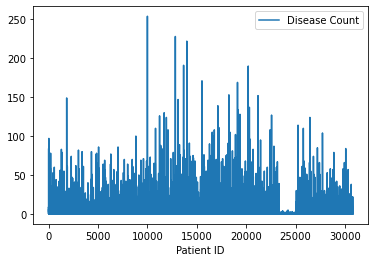

In [25]:
plt.figure(figsize=(16,6))
disease_per_patient.plot()

# 6. Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

-use sample_labels.csv -->sample_df

In [26]:
sample_df

Image Index                                     Finding Labels  \
0     00000013_005.png  Emphysema|Infiltration|Pleural_Thickening|Pneu...   
1     00000013_026.png                             Cardiomegaly|Emphysema   
2     00000017_001.png                                         No Finding   
3     00000030_001.png                                        Atelectasis   
4     00000032_001.png                        Cardiomegaly|Edema|Effusion   
...                ...                                                ...   
5601  00030712_000.png                                         No Finding   
5602  00030786_005.png                    Cardiomegaly|Effusion|Emphysema   
5603  00030789_000.png                                       Infiltration   
5604  00030792_000.png                                         No Finding   
5605  00030797_000.png                                         No Finding   

      Follow-up #  Patient ID Patient Age Patient Gender View Position  \
0               5          13        060Y              M            AP   
1              26          13        057Y              M            AP   
2               1          17        077Y              M            AP   
3               1          30        079Y              M            PA   
4               1          32        055Y              F            AP   
...           ...         ...         ...            ...           ...   
5601            0       30712        058Y              M            PA   
5602            5       30786        061Y              F            AP   
5603            0       30789        052Y              F            PA   
5604            0       30792        010Y              F            PA   
5605            0       30797        024Y              M            PA   

      OriginalImageWidth  OriginalImageHeight  OriginalImagePixelSpacing_x  \
0                   3056                 2544                     0.139000   
1                   2500                 2048                     0.168000   
2                   2500                 2048                     0.168000   
3                   2992                 2991                     0.143000   
4                   2500                 2048                     0.168000   
...                  ...                  ...                          ...   
5601                2021                 2021                     0.194311   
5602                3056                 2544                     0.139000   
5603                2021                 2021                     0.194311   
5604                1775                 1712                     0.194311   
5605                2021                 2021                     0.194311   

      OriginalImagePixelSpacing_y  
0                        0.139000  
1                        0.168000  
2                        0.168000  
3                        0.143000  
4                        0.168000  
...                           ...  
5601                     0.194311  
5602                     0.139000  
5603                     0.194311  
5604                     0.194311  
5605                     0.194311  

[5606 rows x 11 columns]

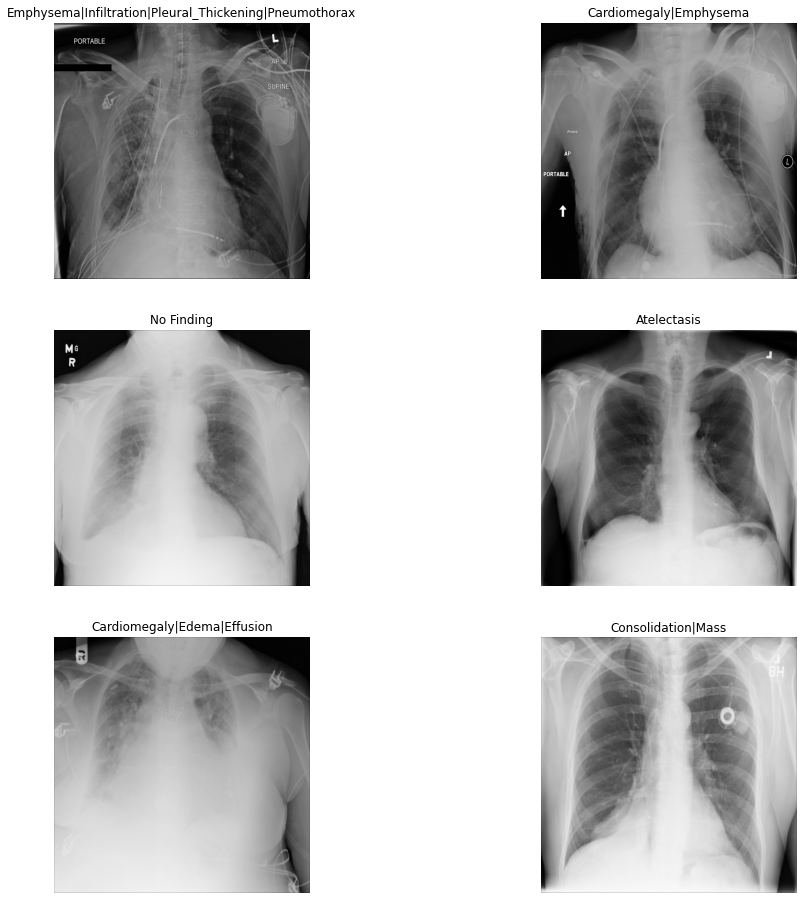

In [27]:
# any labels - just for visualization & testing purposes - remove upon submission
img_paths = [glob(f"/data/images*/*/{i}")[0]for i in sample_df['Image Index'].values]
_,axs = plt.subplots(3,2,figsize = (16,16))
axs = axs.flatten()
for img_path, ax in zip(img_paths, axs):
    img = plt.imread(img_path)
    ax.set_title(sample_df[sample_df['Image Index'] == img_path.split('/')[-1]]['Finding Labels'].values[0])
    ax.axis('Off')
    ax.imshow(img,cmap = 'gray')
plt.show()


# Healthy Xray Visualization + Histograms

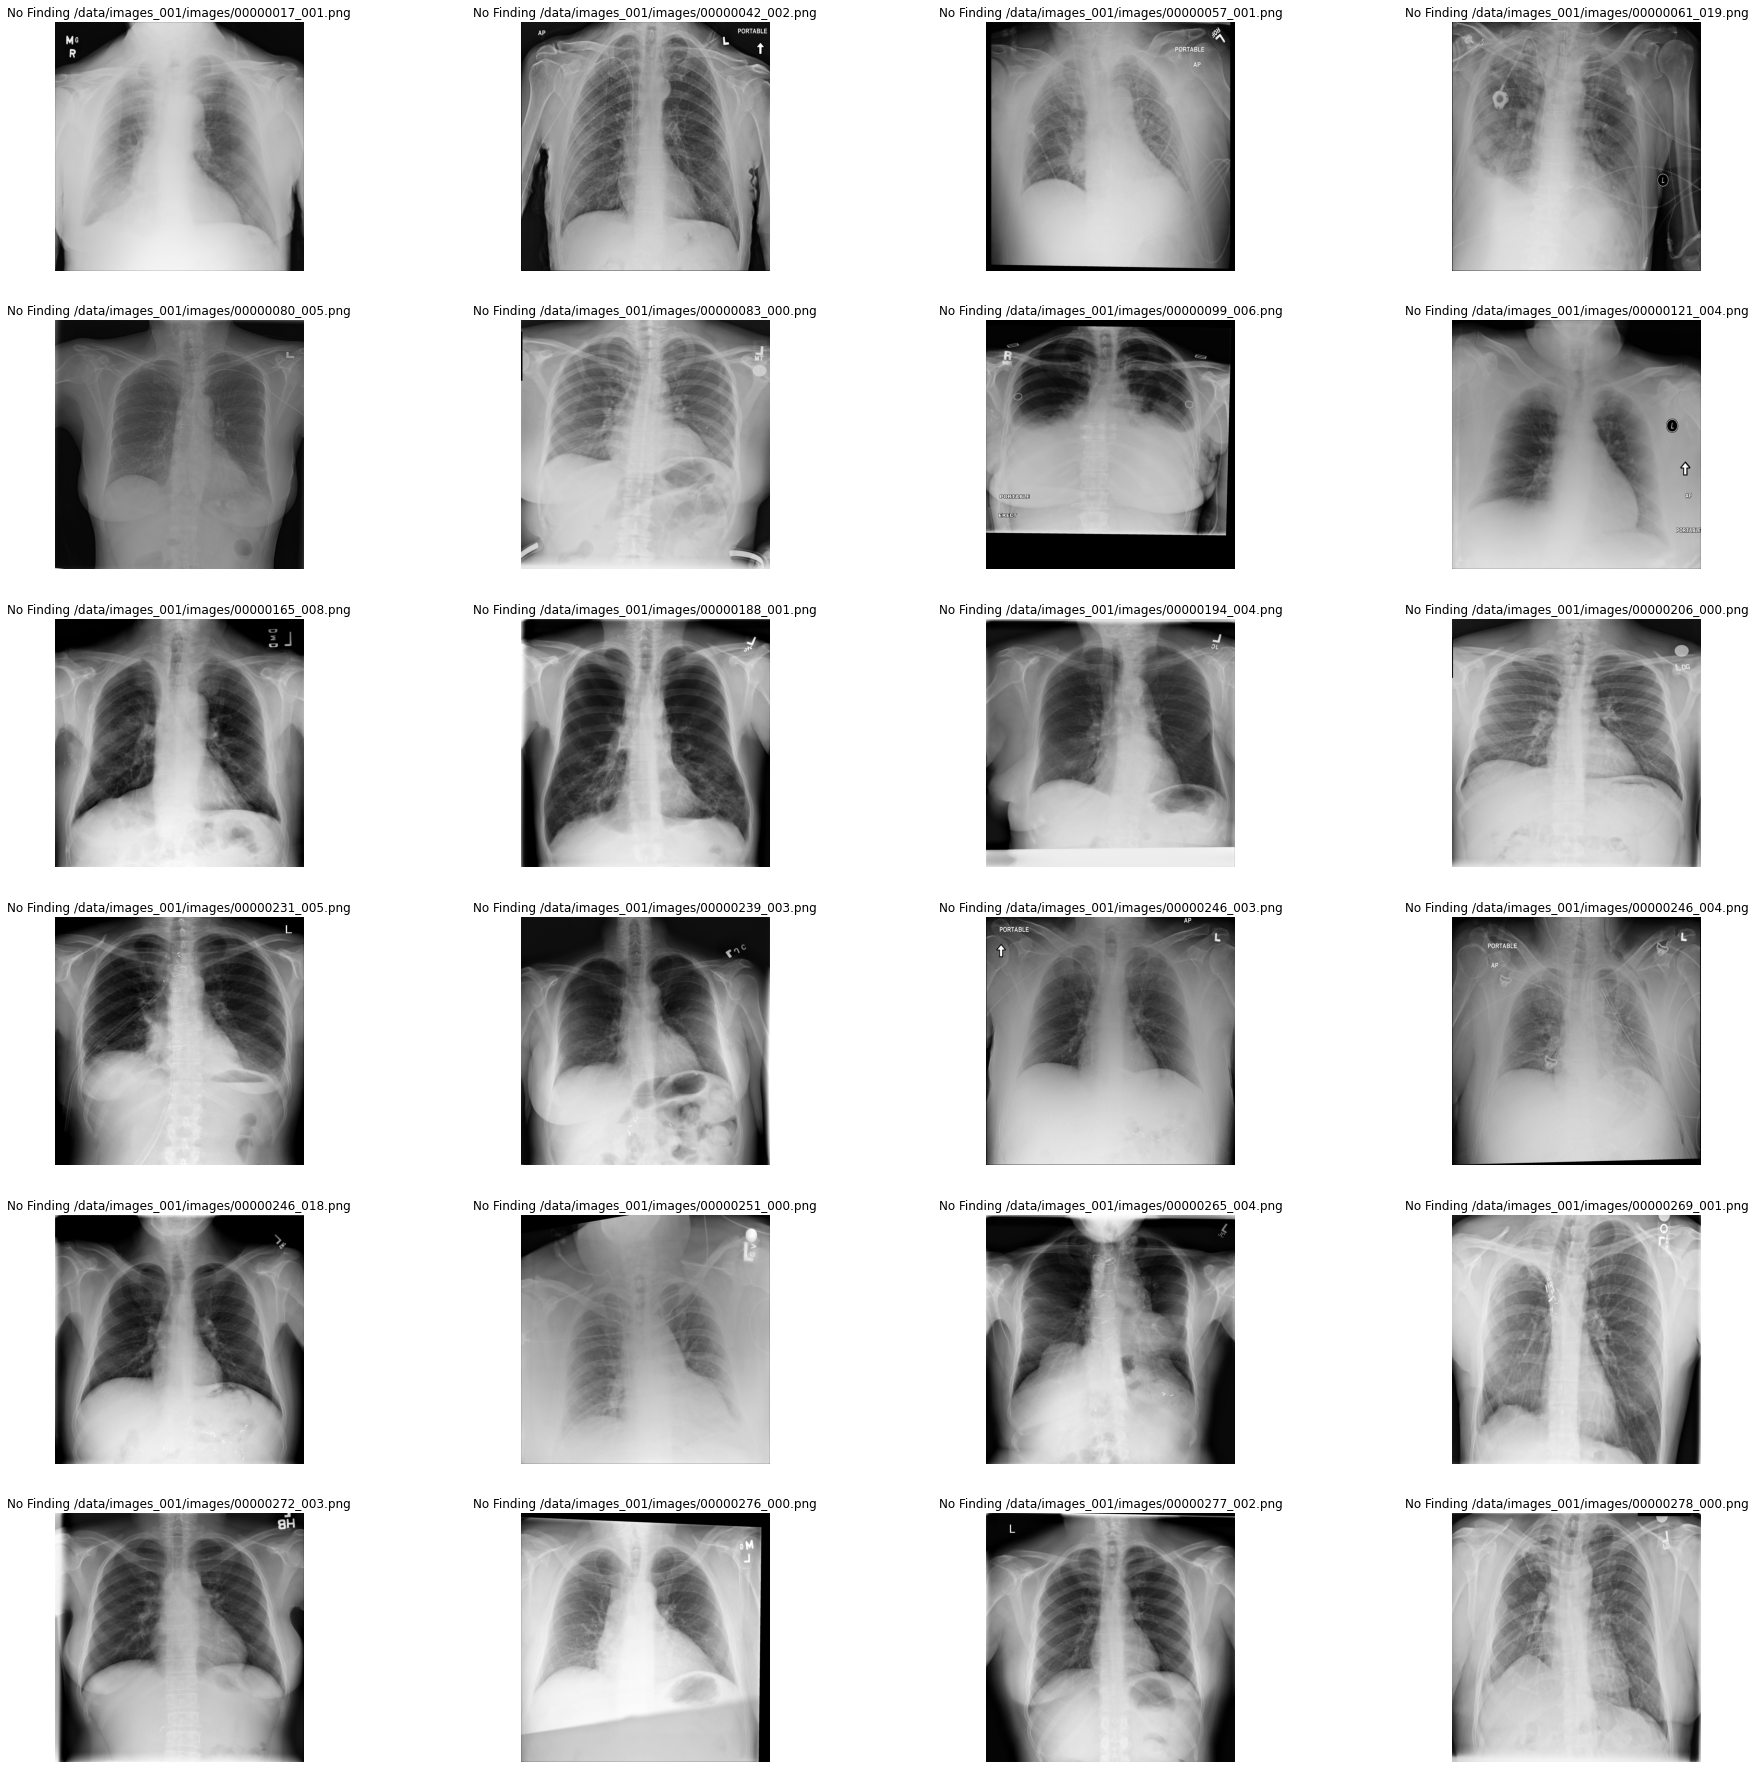

In [28]:
#Healthy data Xray Visualization
#1. get img_paths only of images with 'No Finding Label'
healthy_df = sample_df.loc[sample_df['Finding Labels'] == 'No Finding']
healthy_img_paths = [glob(f"/data/images*/*/{i}")[0]for i in healthy_df['Image Index'].values]
_,axs = plt.subplots(6,4,figsize = (32,32))
axs = axs.flatten()

for img_path, ax in zip(healthy_img_paths, axs):
    img = plt.imread(img_path)
    ax.set_title(healthy_df[healthy_df['Image Index'] == img_path.split('/')[-1]]['Finding Labels'].values[0] + " " + img_path)
    ax.axis('Off')
    ax.imshow(img,cmap = 'gray')
plt.show()

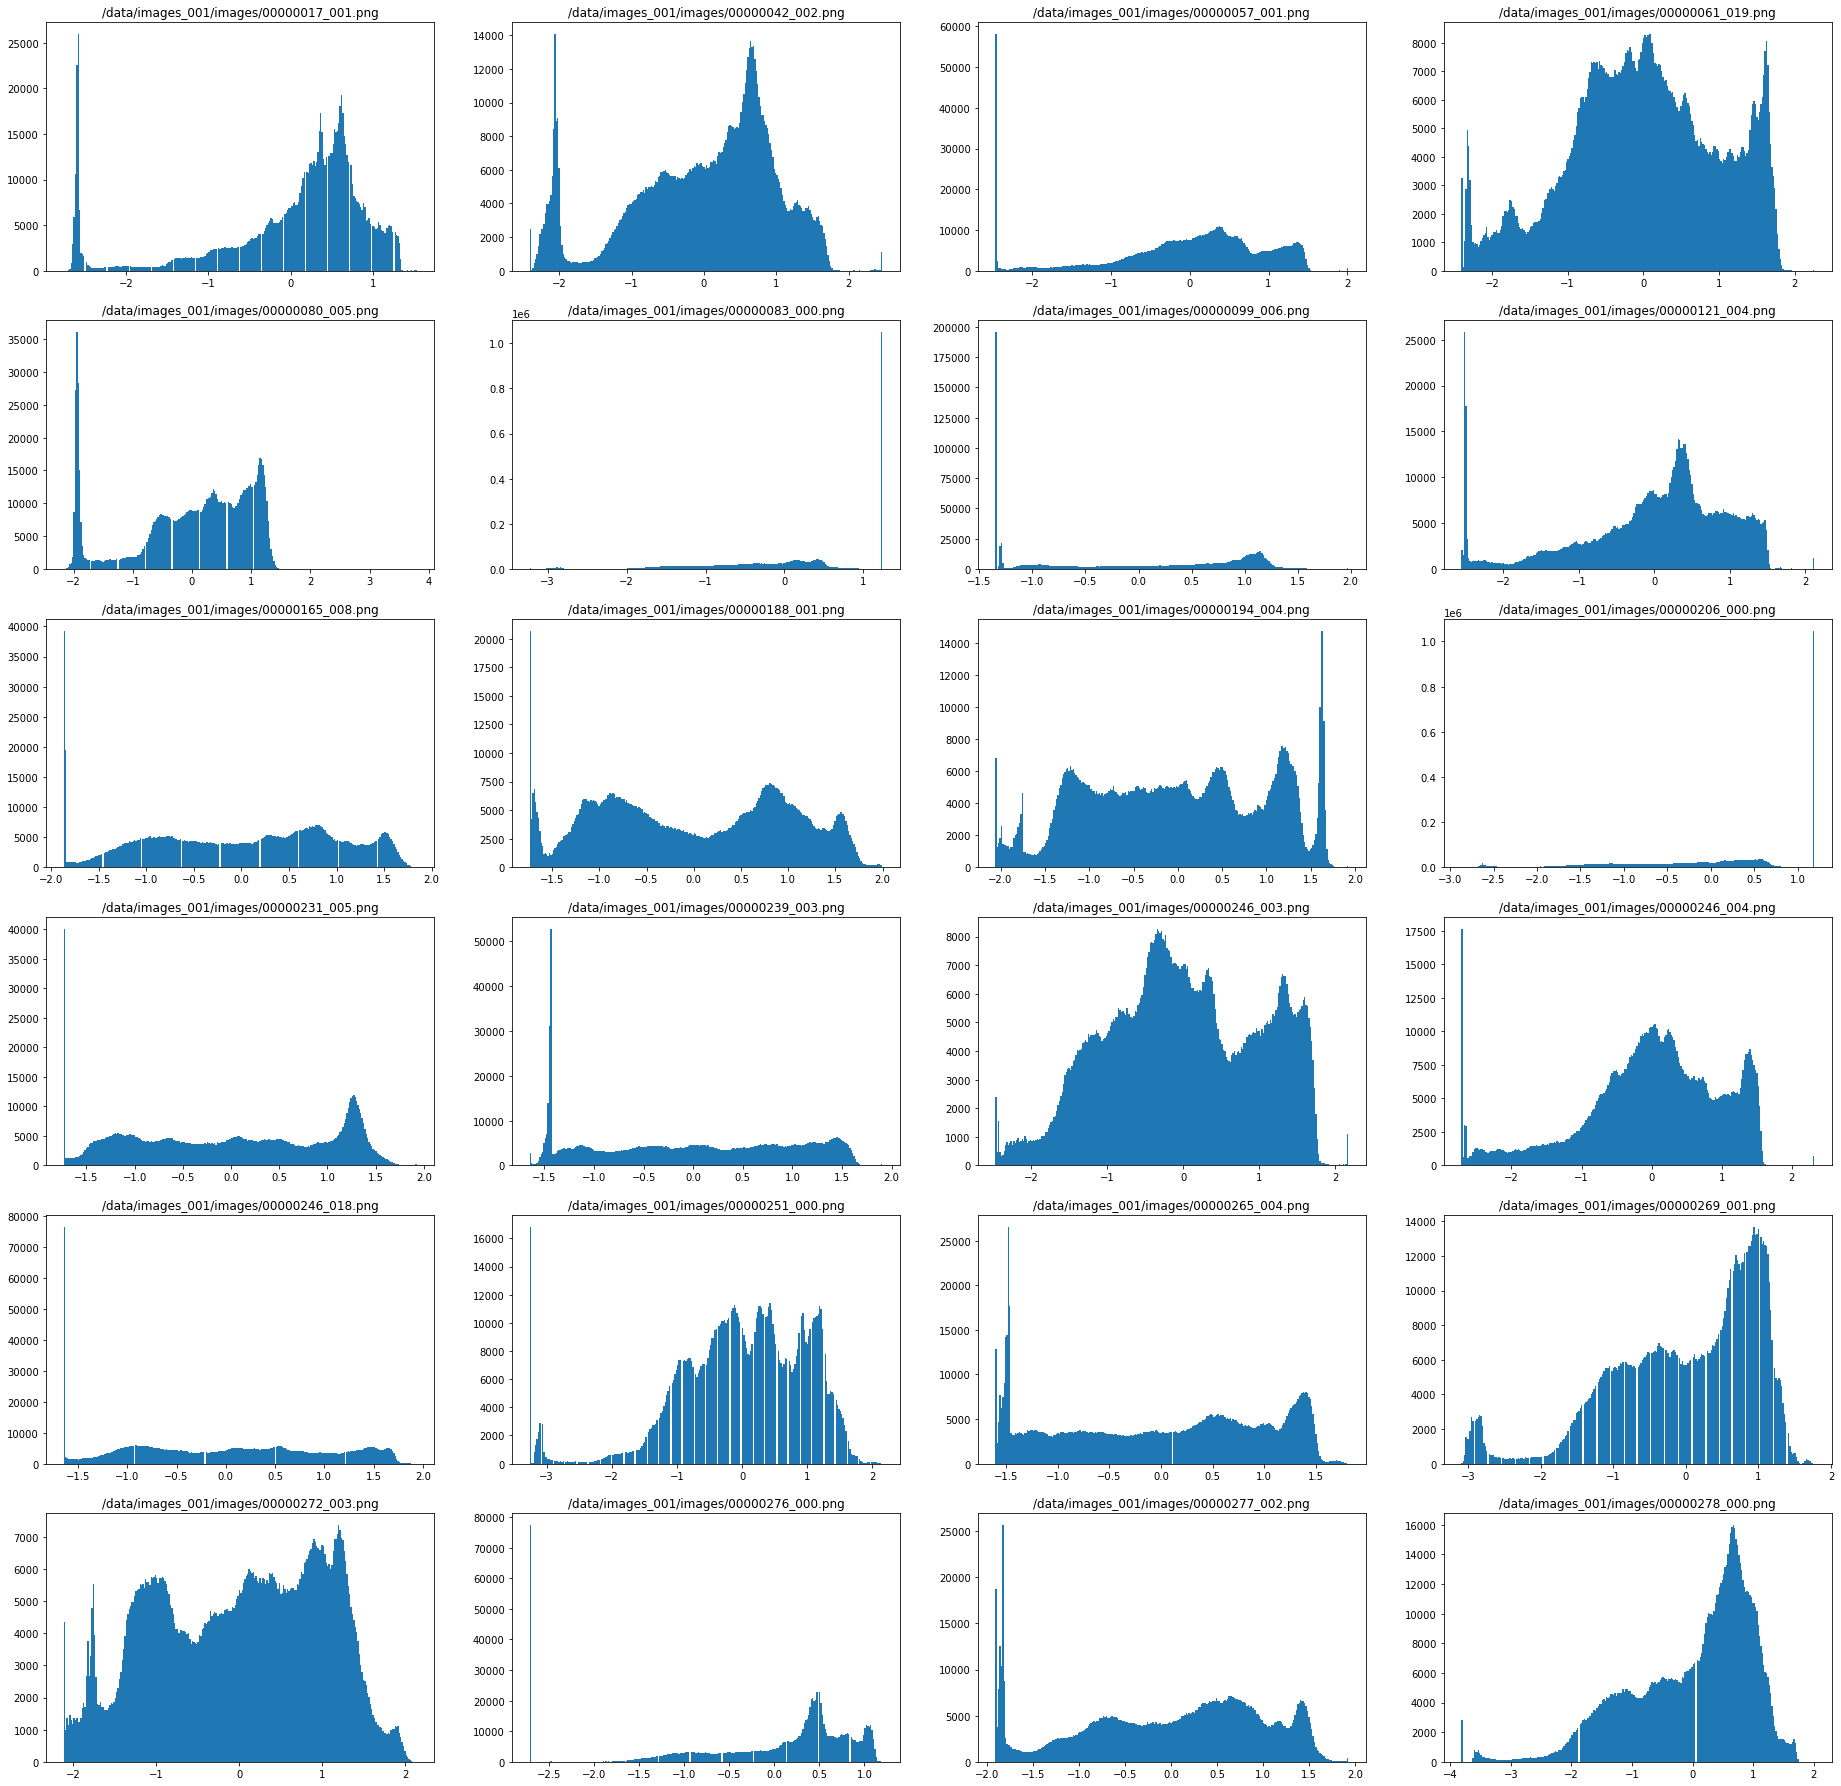

In [29]:
# histograms for healthy data (No Findings Xrays)
fig,axes = plt.subplots(6,4,figsize = (32,32))
for i, (ax, path) in enumerate(zip(axes.flatten(), healthy_img_paths)):
    #read in image
    img =plt.imread(path)
    #standardization
    mean_intensity = np.mean(img)
    std_intensity = np.std(img)
    new_img = img.copy()
    new_img = (new_img - mean_intensity)/std_intensity
    
    #plot the histogram
    ax.hist(new_img.ravel(), bins = 256)
    ax.set_title(path)

plt.show()

# Pneumonia Xray Visualization + Histograms

Note: there are only 14 entries in the histogram that only have 'Pneumonia' under Finding Labels, with no co-occurence of other diseases. 

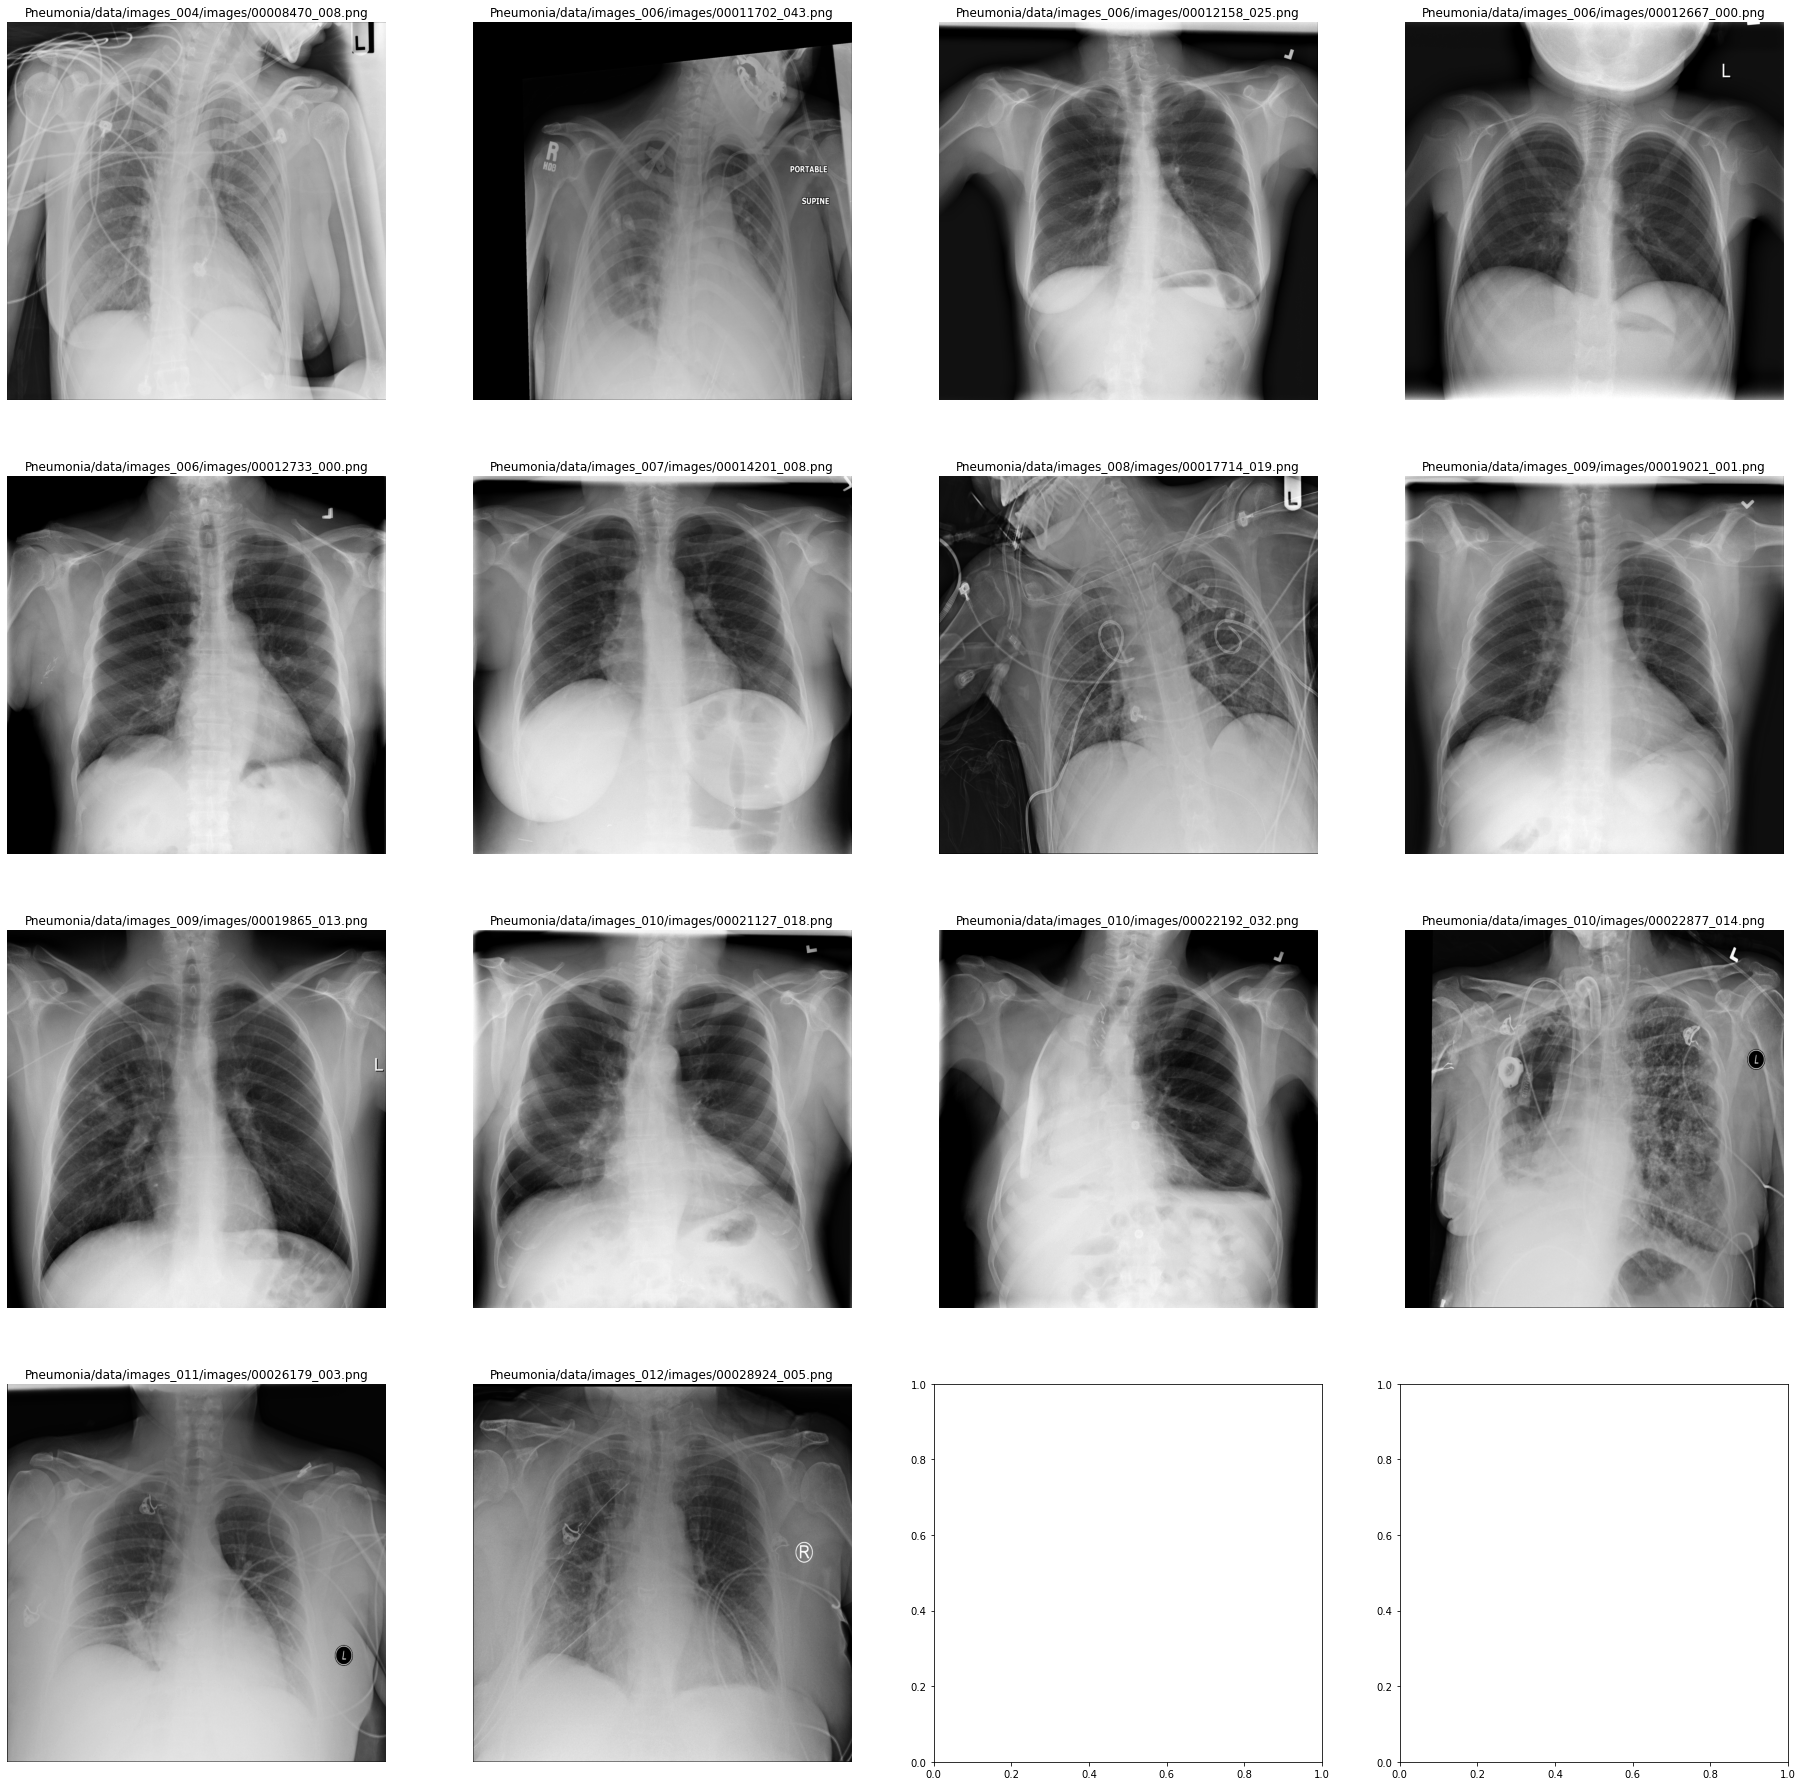

In [30]:
pneumonia_df = sample_df.loc[sample_df['Finding Labels'] == 'Pneumonia']
pneumonia_img_paths = [glob(f"/data/images*/*/{i}")[0]for i in pneumonia_df['Image Index'].values]
_,axs = plt.subplots(4,4,figsize = (32,32))
axs = axs.flatten()

for img_path, ax in zip(pneumonia_img_paths, axs):
    img = plt.imread(img_path)
    ax.set_title(pneumonia_df[pneumonia_df['Image Index'] == img_path.split('/')[-1]]['Finding Labels'].values[0] + img_path)
    ax.axis('Off')
    ax.imshow(img,cmap = 'gray')
plt.show()

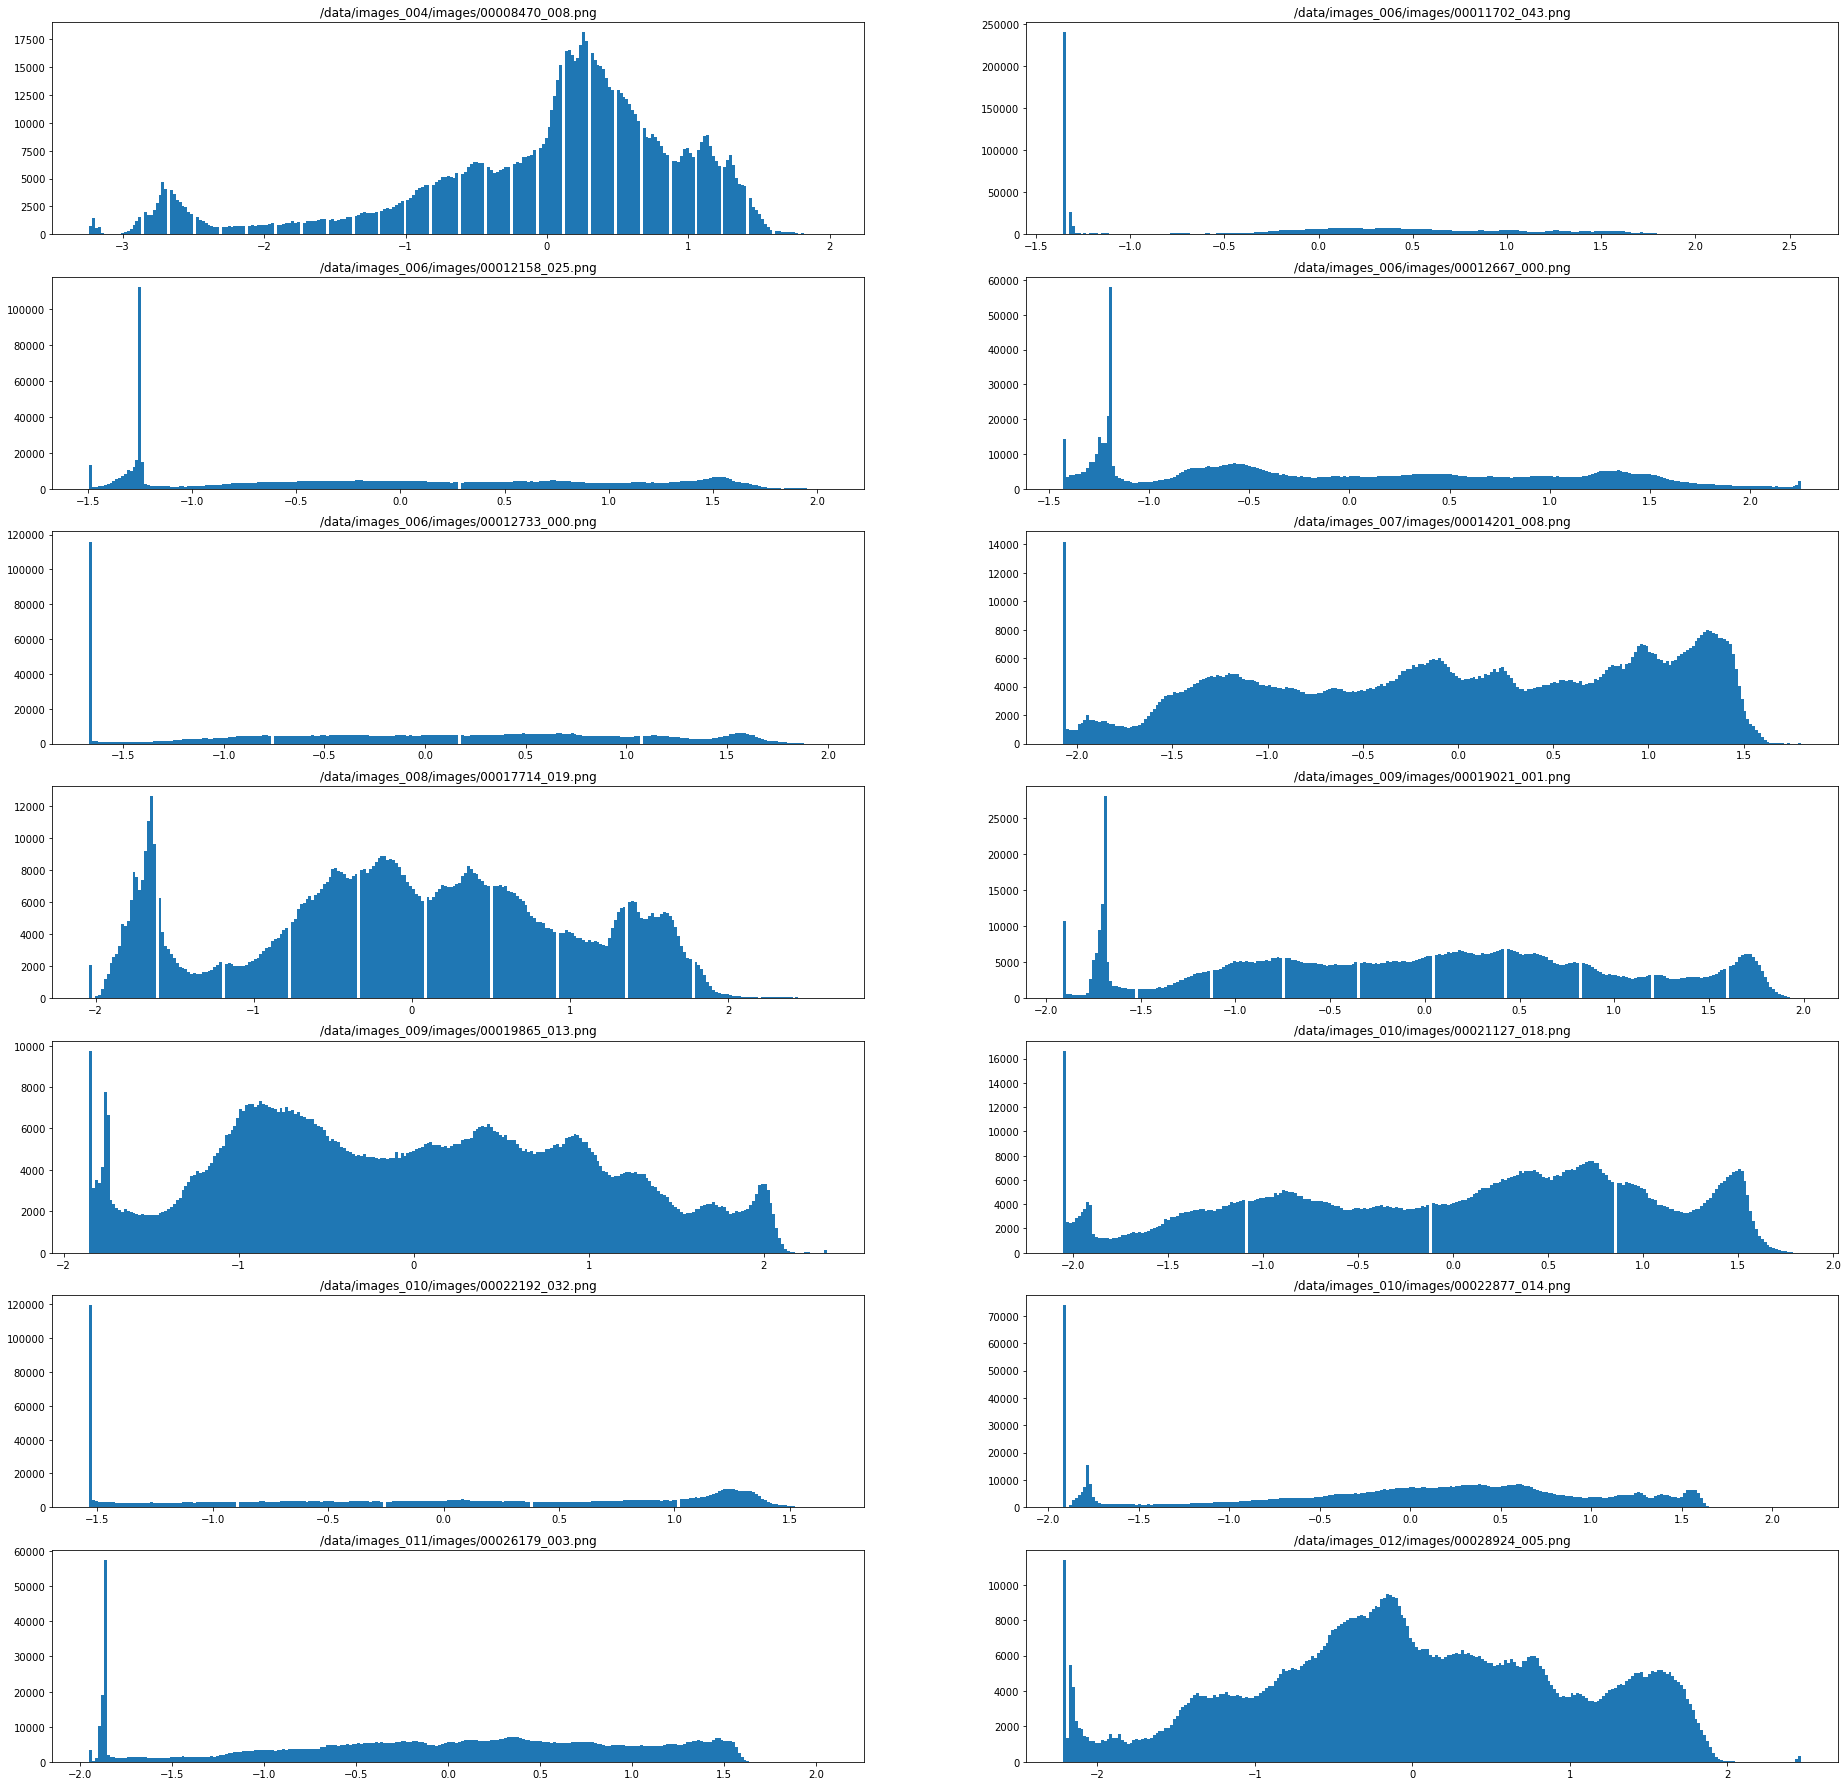

In [31]:
# histograms for pneumonia data (Only Pneumonia Xrays)
fig,axes = plt.subplots(7,2,figsize = (32,32))
for i, (ax, path) in enumerate(zip(axes.flatten(), pneumonia_img_paths)):
    #read in image
    img =plt.imread(path)
    
    #standardization
    mean_intensity = np.mean(img)
    std_intensity = np.std(img)
    new_img = img.copy()
    new_img = (new_img - mean_intensity)/std_intensity

    #plot the histogram
    ax.hist(new_img.ravel(), bins = 256)
    ax.set_title(path)

plt.show()

# Histograms of Pneumonia with Other Diseases

In [32]:
# proportion of each finding label in sample dataset
sample_df['Finding Labels'].value_counts()['Pneumonia']

14

In [33]:
# splitting up the finding labels to map the occurences of each disease as individuals
all_labels = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))

all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
sample_df.head(4)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


Image Index                                     Finding Labels  \
0  00000013_005.png  Emphysema|Infiltration|Pleural_Thickening|Pneu...   
1  00000013_026.png                             Cardiomegaly|Emphysema   
2  00000017_001.png                                         No Finding   
3  00000030_001.png                                        Atelectasis   

   Follow-up #  Patient ID Patient Age Patient Gender View Position  \
0            5          13        060Y              M            AP   
1           26          13        057Y              M            AP   
2            1          17        077Y              M            AP   
3            1          30        079Y              M            PA   

   OriginalImageWidth  OriginalImageHeight  OriginalImagePixelSpacing_x  ...  \
0                3056                 2544                        0.139  ...   
1                2500                 2048                        0.168  ...   
2                2500                 2048                        0.168  ...   
3                2992                 2991                        0.143  ...   

   Emphysema  Fibrosis  Hernia  Infiltration  Mass  No Finding  Nodule  \
0        1.0       0.0     0.0           1.0   0.0         0.0     0.0   
1        1.0       0.0     0.0           0.0   0.0         0.0     0.0   
2        0.0       0.0     0.0           0.0   0.0         1.0     0.0   
3        0.0       0.0     0.0           0.0   0.0         0.0     0.0   

   Pleural_Thickening  Pneumonia  Pneumothorax  
0                 1.0        0.0           1.0  
1                 0.0        0.0           0.0  
2                 0.0        0.0           0.0  
3                 0.0        0.0           0.0  

[4 rows x 26 columns]

In [34]:
# proportion of each finding label in sample dataset
sample_df[all_labels].sum()

Atelectasis            508.0
Cardiomegaly           141.0
Consolidation          226.0
Edema                  118.0
Effusion               644.0
Emphysema              127.0
Fibrosis                84.0
Hernia                  13.0
Infiltration           967.0
Mass                   284.0
No Finding            3044.0
Nodule                 313.0
Pleural_Thickening     176.0
Pneumonia               62.0
Pneumothorax           271.0
dtype: float64